<div align="center">
    <b><h2>МІНІСТЕРСТВО ОСВІТИ І НАУКИ УКРАЇНИ</h2></b><br/>
    <h4>Національний університет “Львівська політехніка”</h4>
    <h4>Кафедра Систем Штучного Інтелекту</h4>
</div>
<br/>
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Nulp_logo_ukr.jpg/948px-Nulp_logo_ukr.jpg" width="500" alt="nulp logo"  />
</center>
<br/><br/><br/><br/>
<div align="center">
    <h4>Лабораторна робота №3</h4>
    <h4>Варіант №18(1)</h4>
    <h4>Звіт з дисципліни "Машинне навчання"</h4>
    <h4>Тема: "Q-learning. Deep Reinforcement learning"</h4>
</div>
<br/><br/><br/>
<br/><br/><br/><br/><br/>
<div align="right">
    <h4><b>Виконав:</b></h4>
    <h4>студент</h4>
    <h4>Орлянський Максим</h4>
    <h4><b>Група:</b></h4>
    <h4>КН-317</h4>
    <h4><b>Прийняв:</b></h4>
    <h4>асистент</h4>
    <h4>Яцишин В. П.</h4>
</div>
<div align="center">
<h5>Львів  2024</h5>
</div>
<br/><br/><br/>
<h5><b>Тема:</b>  Q-learning. Deep Reinforcement learning</h5>
<h5><b>Мета: </b> засвоїти основні відомості при роботі з навчанням з підкріпленням. Навчитись використовувати його на практиці.</h5>
<br/><br/>
<div align="center">
<h1>Завдання лабораторної роботи
</h1>
</div>

 0. Реалізувати алгоритм Q-learning для вирішення середовища Gymnasium згідно варіанту
 1. Ознайомитись з Gymnasium документацією
 2. Ознайомитись з віртуальним середовищем згідно варіанту
 3. Реалізувати алгоритм Q-learning та навчити агента вирішувати поставлену задачу
 4. Зберегти результати навчання щоб можна було показати результати під час здачі лабораторної роботи.
 5. Результат тренування зберегти у файл для можливості відтворення гри під час здачі лабораторної роботи. Ці ж артефакти додати до звіту.
<br/><br/>
<div align="center">
<h1>Розв'язання завдання
</h1>
</div>


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import gymnasium as gym
from gymnasium import wrappers
from gymnasium.wrappers import RecordVideo
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import flappy_bird_gymnasium

Завантажимо середовище Gymnasium для гри Flappy Bird, та переглянемо скільки дій може виконувати інтелектуальний агент в даному середовищі, і що із себе представляє observation space:

In [2]:
env = gym.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=True)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)
ACTION_SIZE = env.action_space.n  
STATE_SIZE = env.observation_space.shape[0]

State shape:  (180,)
Number of actions:  2


Бачимо, що середовище гри Flappy Bird складається лише з 2ох дій, а саме 0 - нічого не робити, 1 - підпригнути. 

Для подальшого створення та тренування моделі Deep Q-Learning задамо гіперпараметри, а також для Є-greedy стратегії що буде використовуватися в основі агента Q-learn параметри Gamma, Tau, EPS 

In [3]:
TRAINING_EPISODES = 300
MAX_MOVES = 1000
LEARNING_RATE = 0.00005
BATCH_SIZE = 512
GAMMA = 0.99
BUFFER_SIZE = int(1e6)
UPDATE = 4
SOFT_UPDATE_RATE = 1e-4
EPS = 0.1
EPS_END = 0.0001
EPS_DECAY = 1e-4
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

Створимо для інтелектуального, агента DQN модель нейронної мережі, що складається 3ох Fully-Conected шарів, та на вхід приймає середовище що спострегіає інтелектуальний агент через gymnasium, а для output шару його дії, в даному випадку вихідний шар міститиме 2 виходи, а саме порухатися чи не рухатися.

In [4]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

На основі створеної моделі DQN, створемо інтелектуального агента, що буде отримувати дані про середовище, навчатиметься та зберігатиме попередні знання про середовище в буфері, і відповідно буде приймати рішення зважаючи на отриману нагороду на попередні етапах, а також у випадку коли потрбіно спробувати новий рух, агент генеруватиме його за допомогою функції sample

In [5]:
class QLAgent:
    def __init__(self, num_of_states, num_of_actions, eps):
        self.num_of_states = num_of_states
        self.num_of_actions = num_of_actions
        self.eps = eps
        self.local_model = DQN(num_of_states, num_of_actions)
        self.target_model = DQN(num_of_states, num_of_actions)
        self.optim = optim.Adam(self.local_model.parameters(), lr=LEARNING_RATE)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.memory = deque(maxlen=BUFFER_SIZE)
        self.iteration_step = 0
        self.loss_history = []

    def sample(self):
        experiences = random.sample(self.memory, k=BATCH_SIZE)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float() / 255.0
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float() / 255.0
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        return (states, actions, rewards, next_states, dones)

    def step(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        self.iteration_step = (self.iteration_step + 1) % UPDATE
        if self.iteration_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.sample()
                self.train(experiences, GAMMA)

    def make_decision(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.local_model.eval()
        with torch.no_grad():
            action_values = self.local_model(state)
        self.local_model.train()

        if random.random() > self.eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.num_of_actions))

    def train(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.local_model(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.loss_history.append(loss.cpu().item())

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        for target_param, local_param in zip(self.target_model.parameters(), self.local_model.parameters()):
            target_param.data.copy_(SOFT_UPDATE_RATE * local_param.data + (1.0 - SOFT_UPDATE_RATE) * target_param.data)

In [6]:
def calculate_reward(state, action, next_state, done):
    reward = 0
    reward += 0.1
    if action == 1 and next_state[0] > state[0]:
        reward += 1.0
    if done:
        reward -= 1.0
    return reward

Тренування-Оцінка моделі в середовищі

In [7]:
env = RecordVideo(env, video_folder="model_train", name_prefix="train",
                  episode_trigger=lambda x: (x % 2) == 0)

agent = QLAgent(STATE_SIZE, ACTION_SIZE, EPS)
scores = []
scores_window = deque(maxlen=1000)
max_reward = -np.Inf

for episode in range(TRAINING_EPISODES):
    state, _ = env.reset()
    score = 0
    for iteration in range(MAX_MOVES):
        action = agent.make_decision(state)
        next_state, _, done, _, _ = env.step(action)
        
        reward = calculate_reward(state, action, next_state, done)
        
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    scores_window.append(score)
    scores.append(score)
    EPS = max(EPS_END, EPS_DECAY * EPS)

    avg_reward = np.mean(scores_window)
    max_reward = max(max_reward, np.max(scores_window))

    print(f'Episode {episode}, Average Reward = {avg_reward}, Max Reward = {max_reward}, Last Reward = {scores[len(scores) - 1]}')

    if scores[len(scores) - 1] >= 10:
        print(f'Environment solved in {episode} episodes!\t Reward = {avg_reward}')
        torch.save(agent.local_model.state_dict(), 'checkpoint.pth')
        break


c:\Users\maxde\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\maxde\OneDrive\Робочий стіл\model_train folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\maxde\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\maxde\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-0.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-0.mp4
Episode 0, Average Reward = 4.999999999999994, Max Reward = 4.999999999999994, Last Reward = 4.999999999999994
Episode 1, Average Reward = 3.849999999999998, Max Reward = 4.999999999999994, Last Reward = 2.700000000000002
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-2.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-2.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-2.mp4
Episode 2, Average Reward = 3.2666666666666657, Max Reward = 4.999999999999994, Last Reward = 2.1000000000000014
Episode 3, Average Reward = 3.449999999999999, Max Reward = 4.999999999999994, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-4.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-4.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-4.mp4
Episode 4, Average Reward = 3.38, Max Reward = 4.999999999999994, Last Reward = 3.100000000000002
Episode 5, Average Reward = 3.6499999999999986, Max Reward = 4.999999999999995, Last Reward = 4.999999999999995
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-6.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-6.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-6.mp4
Episode 6, Average Reward = 3.699999999999999, Max Reward = 4.999999999999995, Last Reward = 3.9999999999999987
Episode 7, Average Reward = 3.862499999999998, Max Reward = 4.999999999999996, Last Reward = 4.999999999999996
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-8.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-8.mp4
Episode 8, Average Reward = 3.877777777777776, Max Reward = 4.999999999999996, Last Reward = 3.9999999999999987
Episode 9, Average Reward = 4.4499999999999975, Max Reward = 9.599999999999985, Last Reward = 9.599999999999985
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-10.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-10.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-10.mp4
Episode 10, Average Reward = 4.445454545454543, Max Reward = 9.599999999999985, Last Reward = 4.399999999999997
Episode 11, Average Reward = 4.716666666666663, Max Reward = 9.599999999999985, Last Reward = 7.699999999999989
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-12.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-12.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-12.mp4
Episode 12, Average Reward = 4.738461538461535, Max Reward = 9.599999999999985, Last Reward = 4.999999999999994
Episode 13, Average Reward = 4.549999999999996, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-14.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-14.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-14.mp4
Episode 14, Average Reward = 4.399999999999997, Max Reward = 9.599999999999985, Last Reward = 2.3000000000000016
Episode 15, Average Reward = 4.3749999999999964, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-16.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-16.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-16.mp4
Episode 16, Average Reward = 4.41176470588235, Max Reward = 9.599999999999985, Last Reward = 4.999999999999998
Episode 17, Average Reward = 4.388888888888886, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-18.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-18.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-18.mp4
Episode 18, Average Reward = 4.368421052631576, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Episode 19, Average Reward = 4.334999999999997, Max Reward = 9.599999999999985, Last Reward = 3.6999999999999997
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-20.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-20.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-20.mp4
Episode 20, Average Reward = 4.319047619047616, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Episode 21, Average Reward = 4.349999999999998, Max Reward = 9.599999999999985, Last Reward = 4.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-22.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-22.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-22.mp4
Episode 22, Average Reward = 4.252173913043476, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Episode 23, Average Reward = 4.254166666666664, Max Reward = 9.599999999999985, Last Reward = 4.299999999999997
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-24.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-24.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-24.mp4
Episode 24, Average Reward = 4.243999999999997, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Episode 25, Average Reward = 4.27307692307692, Max Reward = 9.599999999999985, Last Reward = 4.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-26.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-26.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-26.mp4
Episode 26, Average Reward = 4.329629629629627, Max Reward = 9.599999999999985, Last Reward = 5.799999999999995
Episode 27, Average Reward = 4.353571428571426, Max Reward = 9.599999999999985, Last Reward = 4.999999999999995
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-28.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-28.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-28.mp4
Episode 28, Average Reward = 4.275862068965515, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Episode 29, Average Reward = 4.299999999999998, Max Reward = 9.599999999999985, Last Reward = 4.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-30.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-30.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-30.mp4
Episode 30, Average Reward = 4.229032258064514, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Episode 31, Average Reward = 4.221874999999997, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-32.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-32.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-32.mp4
Episode 32, Average Reward = 4.2454545454545425, Max Reward = 9.599999999999985, Last Reward = 4.999999999999998
Episode 33, Average Reward = 4.235294117647056, Max Reward = 9.599999999999985, Last Reward = 3.899999999999999
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-34.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-34.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-34.mp4
Episode 34, Average Reward = 4.2571428571428545, Max Reward = 9.599999999999985, Last Reward = 4.9999999999999964
Episode 35, Average Reward = 4.249999999999997, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-36.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-36.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-36.mp4
Episode 36, Average Reward = 4.229729729729727, Max Reward = 9.599999999999985, Last Reward = 3.5000000000000004
Episode 37, Average Reward = 4.276315789473682, Max Reward = 9.599999999999985, Last Reward = 5.999999999999995
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-38.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-38.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-38.mp4
Episode 38, Average Reward = 4.294871794871793, Max Reward = 9.599999999999985, Last Reward = 4.999999999999998
Episode 39, Average Reward = 4.312499999999997, Max Reward = 9.599999999999985, Last Reward = 4.999999999999995
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-40.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-40.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-40.mp4
Episode 40, Average Reward = 4.304878048780485, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Episode 41, Average Reward = 4.316666666666664, Max Reward = 9.599999999999985, Last Reward = 4.7999999999999945
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-42.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-42.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-42.mp4
Episode 42, Average Reward = 4.2651162790697645, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Episode 43, Average Reward = 4.259090909090906, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-44.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-44.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-44.mp4
Episode 44, Average Reward = 4.2755555555555524, Max Reward = 9.599999999999985, Last Reward = 4.999999999999998
Episode 45, Average Reward = 4.2695652173913015, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-46.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-46.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-46.mp4
Episode 46, Average Reward = 4.242553191489359, Max Reward = 9.599999999999985, Last Reward = 3.000000000000002
Episode 47, Average Reward = 4.237499999999998, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-48.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-48.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-48.mp4
Episode 48, Average Reward = 4.193877551020406, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Episode 49, Average Reward = 4.1919999999999975, Max Reward = 9.599999999999985, Last Reward = 4.099999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-50.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-50.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-50.mp4
Episode 50, Average Reward = 4.188235294117645, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Episode 51, Average Reward = 4.215384615384613, Max Reward = 9.599999999999985, Last Reward = 5.599999999999994
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-52.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-52.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-52.mp4
Episode 52, Average Reward = 4.211320754716978, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Episode 53, Average Reward = 4.225925925925924, Max Reward = 9.599999999999985, Last Reward = 4.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-54.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-54.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-54.mp4
Episode 54, Average Reward = 4.230909090909089, Max Reward = 9.599999999999985, Last Reward = 4.4999999999999964
Episode 55, Average Reward = 4.287499999999998, Max Reward = 9.599999999999985, Last Reward = 7.39999999999999
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-56.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-56.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-56.mp4
Episode 56, Average Reward = 4.282456140350875, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Episode 57, Average Reward = 4.2448275862068945, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-58.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-58.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-58.mp4
Episode 58, Average Reward = 4.240677966101693, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Episode 59, Average Reward = 4.204999999999997, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-60.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-60.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-60.mp4
Episode 60, Average Reward = 4.170491803278686, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Episode 61, Average Reward = 4.1677419354838685, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-62.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-62.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-62.mp4
Episode 62, Average Reward = 4.165079365079363, Max Reward = 9.599999999999985, Last Reward = 3.9999999999999987
Episode 63, Average Reward = 4.132812499999998, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-64.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-64.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-64.mp4
Episode 64, Average Reward = 4.155384615384614, Max Reward = 9.599999999999985, Last Reward = 5.599999999999996
Episode 65, Average Reward = 4.124242424242423, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-66.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-66.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-66.mp4
Episode 66, Average Reward = 4.094029850746268, Max Reward = 9.599999999999985, Last Reward = 2.1000000000000014
Episode 67, Average Reward = 4.127941176470587, Max Reward = 9.599999999999985, Last Reward = 6.399999999999993
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-68.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-68.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-68.mp4
Episode 68, Average Reward = 4.211594202898549, Max Reward = 9.89999999999998, Last Reward = 9.89999999999998
Episode 69, Average Reward = 4.181428571428571, Max Reward = 9.89999999999998, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-70.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-70.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-70.mp4
Episode 70, Average Reward = 4.178873239436618, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Episode 71, Average Reward = 4.149999999999998, Max Reward = 9.89999999999998, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-72.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-72.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-72.mp4
Episode 72, Average Reward = 4.179452054794519, Max Reward = 9.89999999999998, Last Reward = 6.299999999999994
Episode 73, Average Reward = 4.15135135135135, Max Reward = 9.89999999999998, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-74.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-74.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-74.mp4
Episode 74, Average Reward = 4.149333333333332, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Episode 75, Average Reward = 4.12236842105263, Max Reward = 9.89999999999998, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-76.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-76.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-76.mp4
Episode 76, Average Reward = 4.1207792207792195, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Episode 77, Average Reward = 4.094871794871794, Max Reward = 9.89999999999998, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-78.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-78.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-78.mp4
Episode 78, Average Reward = 4.093670886075948, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Episode 79, Average Reward = 4.068749999999998, Max Reward = 9.89999999999998, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-80.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-80.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-80.mp4
Episode 80, Average Reward = 4.0629629629629616, Max Reward = 9.89999999999998, Last Reward = 3.6
Episode 81, Average Reward = 4.062195121951218, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-82.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-82.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-82.mp4
Episode 82, Average Reward = 4.061445783132529, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Episode 83, Average Reward = 4.079761904761902, Max Reward = 9.89999999999998, Last Reward = 5.5999999999999925
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-84.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-84.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-84.mp4
Episode 84, Average Reward = 4.090588235294115, Max Reward = 9.89999999999998, Last Reward = 4.999999999999994
Episode 85, Average Reward = 4.089534883720928, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-86.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-86.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-86.mp4
Episode 86, Average Reward = 4.088505747126435, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Episode 87, Average Reward = 4.065909090909089, Max Reward = 9.89999999999998, Last Reward = 2.1000000000000014
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-88.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-88.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-88.mp4
Episode 88, Average Reward = 4.065168539325841, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Episode 89, Average Reward = 4.075555555555554, Max Reward = 9.89999999999998, Last Reward = 4.999999999999997
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-90.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-90.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-90.mp4
Episode 90, Average Reward = 4.085714285714284, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Episode 91, Average Reward = 4.095652173913042, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-92.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-92.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-92.mp4
Episode 92, Average Reward = 4.10537634408602, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Episode 93, Average Reward = 4.130851063829786, Max Reward = 9.89999999999998, Last Reward = 6.499999999999993
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-94.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-94.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-94.mp4
Episode 94, Average Reward = 4.129473684210525, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Episode 95, Average Reward = 4.138541666666664, Max Reward = 9.89999999999998, Last Reward = 4.9999999999999964
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-96.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-96.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-96.mp4
Episode 96, Average Reward = 4.137113402061853, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Episode 97, Average Reward = 4.145918367346937, Max Reward = 9.89999999999998, Last Reward = 4.999999999999994
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-98.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-98.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-98.mp4
Episode 98, Average Reward = 4.164646464646462, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 99, Average Reward = 4.182999999999998, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-100.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-100.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-100.mp4
Episode 100, Average Reward = 4.200990099009899, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 101, Average Reward = 4.208823529411762, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-102.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-102.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-102.mp4
Episode 102, Average Reward = 4.226213592233008, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 103, Average Reward = 4.233653846153844, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-104.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-104.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-104.mp4
Episode 104, Average Reward = 4.2504761904761885, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 105, Average Reward = 4.26698113207547, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-106.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-106.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-106.mp4
Episode 106, Average Reward = 4.283177570093456, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 107, Average Reward = 4.299074074074072, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-108.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-108.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-108.mp4
Episode 108, Average Reward = 4.314678899082566, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 109, Average Reward = 4.329999999999998, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-110.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-110.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-110.mp4
Episode 110, Average Reward = 4.345045045045043, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 111, Average Reward = 4.350892857142855, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-112.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-112.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-112.mp4
Episode 112, Average Reward = 4.365486725663715, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 113, Average Reward = 4.379824561403507, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-114.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-114.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-114.mp4
Episode 114, Average Reward = 4.393913043478259, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 115, Average Reward = 4.407758620689654, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-116.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-116.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-116.mp4
Episode 116, Average Reward = 4.421367521367519, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 117, Average Reward = 4.434745762711862, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-118.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-118.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-118.mp4
Episode 118, Average Reward = 4.447899159663863, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 119, Average Reward = 4.460833333333331, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-120.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-120.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-120.mp4
Episode 120, Average Reward = 4.465289256198345, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Episode 121, Average Reward = 4.4778688524590144, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-122.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-122.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-122.mp4
Episode 122, Average Reward = 4.490243902439023, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 123, Average Reward = 4.5024193548387075, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-124.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-124.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-124.mp4
Episode 124, Average Reward = 4.5063999999999975, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Episode 125, Average Reward = 4.518253968253966, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-126.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-126.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-126.mp4
Episode 126, Average Reward = 4.529921259842517, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 127, Average Reward = 4.541406249999998, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-128.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-128.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-128.mp4
Episode 128, Average Reward = 4.5449612403100765, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Episode 129, Average Reward = 4.556153846153845, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-130.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-130.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-130.mp4
Episode 130, Average Reward = 4.567175572519083, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 131, Average Reward = 4.578030303030302, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-132.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-132.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-132.mp4
Episode 132, Average Reward = 4.588721804511277, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 133, Average Reward = 4.599253731343282, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-134.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-134.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-134.mp4
Episode 134, Average Reward = 4.609629629629628, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 135, Average Reward = 4.619852941176469, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-136.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-136.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-136.mp4
Episode 136, Average Reward = 4.629927007299269, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 137, Average Reward = 4.639855072463767, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-138.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-138.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-138.mp4
Episode 138, Average Reward = 4.649640287769783, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 139, Average Reward = 4.659285714285713, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-140.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-140.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-140.mp4
Episode 140, Average Reward = 4.668794326241134, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 141, Average Reward = 4.6711267605633795, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-142.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-142.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-142.mp4
Episode 142, Average Reward = 4.68041958041958, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 143, Average Reward = 4.689583333333331, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-144.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-144.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-144.mp4
Episode 144, Average Reward = 4.69862068965517, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 145, Average Reward = 4.7075342465753405, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-146.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-146.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-146.mp4
Episode 146, Average Reward = 4.716326530612243, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 147, Average Reward = 4.724999999999998, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-148.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-148.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-148.mp4
Episode 148, Average Reward = 4.733557046979864, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 149, Average Reward = 4.741999999999998, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-150.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-150.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-150.mp4
Episode 150, Average Reward = 4.750331125827813, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 151, Average Reward = 4.7585526315789455, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-152.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-152.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-152.mp4
Episode 152, Average Reward = 4.7601307189542466, Max Reward = 9.89999999999998, Last Reward = 4.999999999999998
Episode 153, Average Reward = 4.768181818181817, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-154.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-154.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-154.mp4
Episode 154, Average Reward = 4.776129032258063, Max Reward = 9.89999999999998, Last Reward = 5.999999999999998
Episode 155, Average Reward = 4.771153846153845, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-156.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-156.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-156.mp4
Episode 156, Average Reward = 4.766242038216559, Max Reward = 9.89999999999998, Last Reward = 3.9999999999999987
Episode 157, Average Reward = 4.809493670886074, Max Reward = 11.599999999999985, Last Reward = 11.599999999999985
Environment solved in 157 episodes!	 Reward = 4.809493670886074


Візуалізуємо отримані результати навчання моделі DQL:

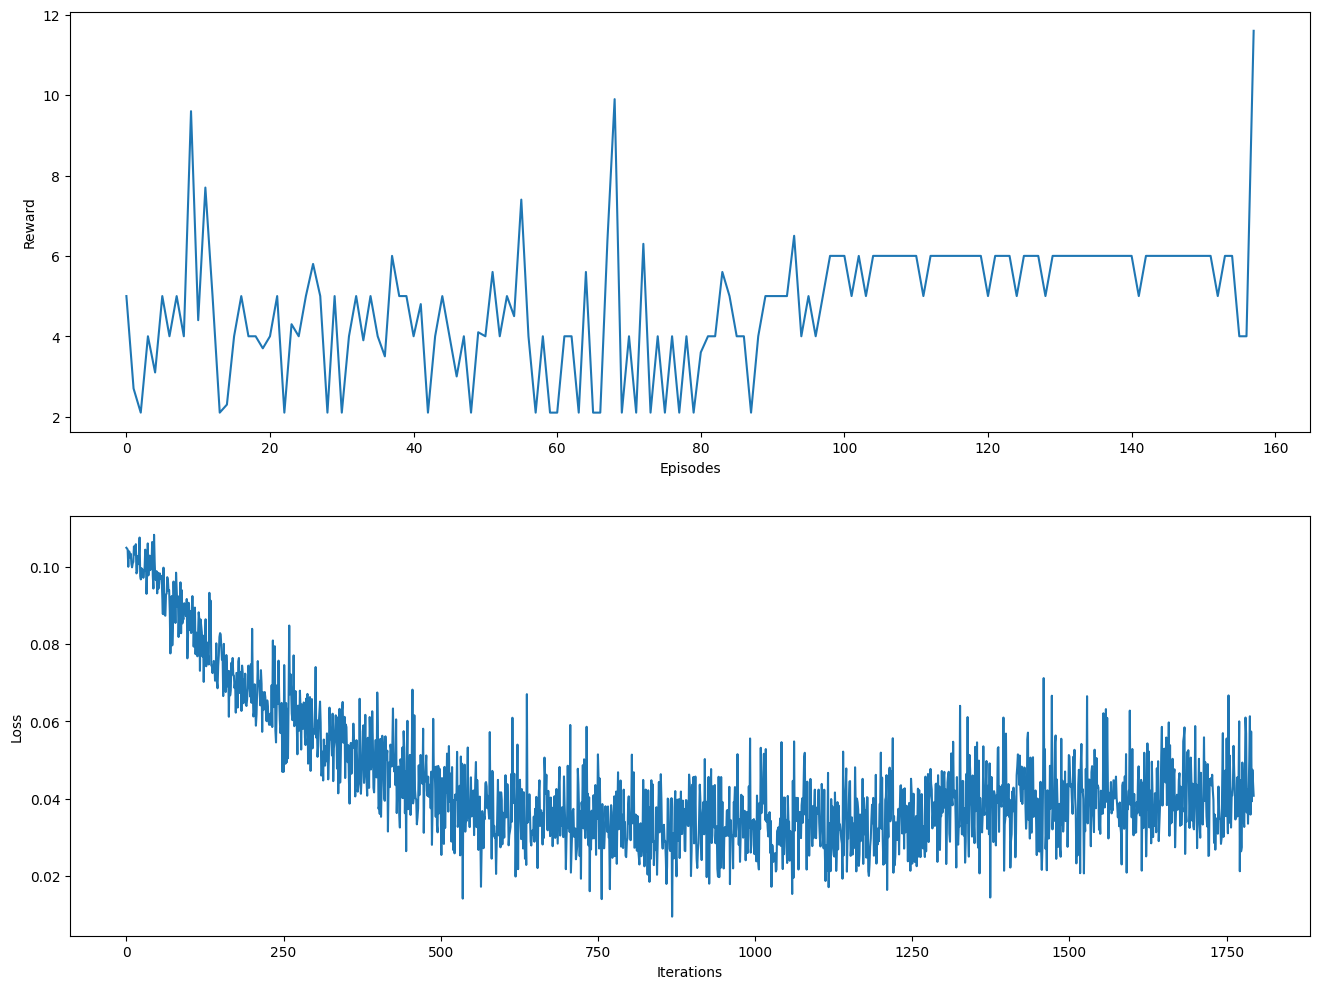

Moviepy - Building video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-158.mp4.
Moviepy - Writing video c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-158.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\maxde\OneDrive\Робочий стіл\model_train\train-episode-158.mp4


In [8]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
ax[0].plot(np.arange(len(scores)), scores)
ax[0].set_ylabel('Reward')
ax[0].set_xlabel('Episodes')
ax[1].plot(np.arange(len(agent.loss_history)), agent.loss_history)
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Iterations')
plt.show()
env.close()

Тестування отриманого DQL агента, в середовиші Flappy Bird, із загрузкою ваг із навченої моделі:

In [10]:
env = gym.make('FlappyBird-v0', render_mode="human")
agent = QLAgent(STATE_SIZE, ACTION_SIZE, EPS)
agent.local_model.load_state_dict(torch.load('checkpoint.pth'))
NUM_EPISODES = 1
MAX_ITERATIONS = 1000

for i in range(NUM_EPISODES):
    state, _ = env.reset(seed=0)
    score = 0
    for j in range(MAX_ITERATIONS):
        action = agent.make_decision(state)
        env.render()
        state, reward, done, _, _ = env.step(action)
        score += reward
        if done:
            break

    print(f'Episode = {i}, score = {score}')

env.close()

Episode = 0, score = 6.4999999999999645


# **Висновок**
### У процесі виконання лабораторної роботи я, розробив інтелектуального агента Deep Q-Learn з використанням Reinforcement Learning, та засвоїв основні відомості при роботі з навчанням з підкріпленням. Навчився використовувати його на практиці, сформував модель нейронної мережі для інтелектуального агента DQL, та підібрав йому оптимальні гіперпараметри для якможна кращого reward значення моделі в середовищі Flappy Bird


